<a href="https://colab.research.google.com/github/sftSalman/transferLearning/blob/main/ResnetCFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

%matplotlib inline
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.8.2


In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
#@title Visualization Utilities [RUN ME]
# matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor="F8F8F8", titlesize="large", edgecolor="white")
plt.rc('text', color="A8151A")
plt.rc('figure', facecolor="F0F0F0")
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.yticks([])
    plt.xticks([])
    plt.imshow(n_digits[i])
  plt.show()
  
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


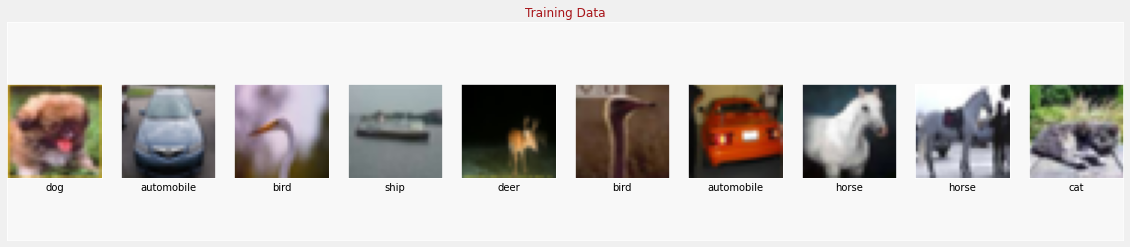

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data")

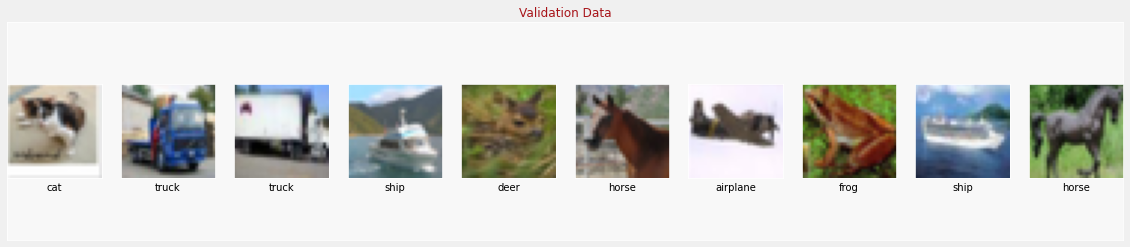

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Validation Data")

In [15]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [16]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [17]:
def feature_extractor(inputs):
  
  feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet')(inputs)
  return feature_extractor

                                                    

In [18]:
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
  return x

In [19]:
def final_model(inputs):

  resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)

  return classification_output

In [20]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model

model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [21]:
EPOCHS = 4
history = model.fit(train_X, training_labels,
                    epochs=EPOCHS,
                    validation_data=(valid_X, validation_labels))

Epoch 1/4
1563/1563 [==============================] - 588s 366ms/step - loss: 0.3458 - accuracy: 0.8855 - val_loss: 0.1767 - val_accuracy: 0.9392
Epoch 2/4
 152/1563 [=>............................] - ETA: 8:19 - loss: 0.0966 - accuracy: 0.9679

KeyboardInterrupt: ignored

In [22]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 33s 202ms/step - loss: 0.1525 - accuracy: 0.9487


NameError: ignored

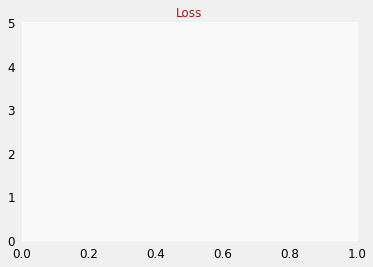

In [23]:
plot_metrics("loss", "Loss")

NameError: ignored

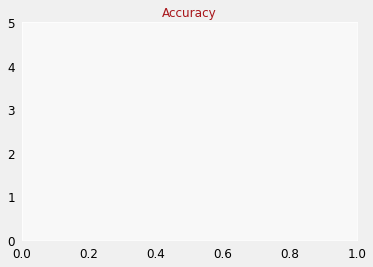

In [24]:
plot_metrics("accuracy", "Accuracy")

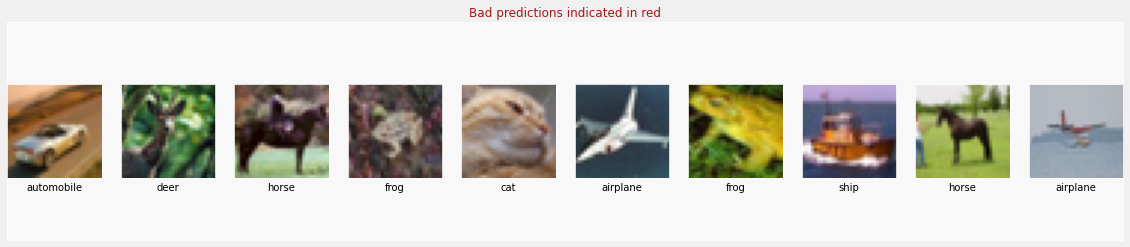

In [25]:
predictions = model.predict(valid_X, batch_size=64)
predictions = np.argmax(predictions, axis=1)

display_images(validation_images, predictions, validation_labels, "Bad predictions indicated in red")